# Chest X-Ray Vison

## 1. Problem
This notebook is a simple example of using a pre-trained model to classify chest x-rays. The model is trained on the NIH Chest X-Ray dataset, which contains 112,120 images of chest x-rays. The dataset is split into 14 classes, which are:
- Atelectasis
- Cardiomegaly
- Effusion
- Infiltration
- Mass
- Nodule
- Pneumonia
- Pneumothorax
- Consolidation
- Edema
- Emphysema
- Fibrosis
- Pleural_Thickening
- Hernia
- No Finding

When I receive new chest x-rays, I want to be able to quickly classify them into one of these 14 classes. This will help me to quickly identify the most important x-rays to review.

## 2. Data
The data is available on Kaggle at https://www.kaggle.com/nih-chest-xrays/data. and was downloaded and extracted to the data folder.
Data was distributed into 12 directories


## 3. Evaluation
Evaluation is prediction probability of each class for each image. The evaluation metric is the mean average precision at different intersection over union (IoU) thresholds. The model will be evaluated on the test set.


In [53]:
import bitarray as bitarray
import tensorflow as tf
import tensorflow_hub as hub

tf.__version__ , hub.__version__

('2.11.0', '0.12.0')

## 2. Data exploration / preprocessing

Now we'll prepare the data for the model. We'll do the following:
- Load images paths from the data folder
- Load labels from the data/Data_Entry_2017.csv file and other features
- One-hot encode labels
- Remove nan values if any and remove unused columns
- Split data into train and test sets
- Create tf.data.Dataset from train and test sets

In [54]:
# Dataset was downloaded from https://www.kaggle.com/datasets/nih-chest-xrays/data and extracted to the data folder
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Pandas table of all images (*.png) paths from the data folder
import pandas as pd
import glob

image_paths = glob.glob("data/images_*/images/*.png")
data = pd.DataFrame(image_paths, columns=["image_path"])
# Add column with filename
data["filename"] = data["image_path"].apply(lambda x: x.split("/")[-1])
data.head()

,image_path,filename
0,data/images_006/images/00011723_001.png,00011723_001.png
1,data/images_006/images/00013648_003.png,00013648_003.png
2,data/images_006/images/00011945_002.png,00011945_002.png
3,data/images_006/images/00012342_003.png,00012342_003.png
4,data/images_006/images/00011955_002.png,00011955_002.png


In [55]:
# Concatenation image_paths with data/Data_Entry_2017.csv where filename is the same as column "Filename"
data_entry = pd.read_csv("data/Data_Entry_2017.csv")

In [56]:
# row count compare of data and data_entry
print("Images count matches data entries! :)") if data.shape[0] == data_entry.shape[0] else print("Images count doesn't match data entries! :(")

Images count matches data entries! :)


In [57]:
data = pd.merge(data, data_entry, left_on="filename", right_on="Image Index")
data.drop(columns=["filename", "Image Index", "OriginalImage[Width", "Height]", "OriginalImagePixelSpacing[x", "y]", "Unnamed: 11"], inplace=True)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112120 entries, 0 to 112119
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_path      112120 non-null  object
 1   Finding Labels  112120 non-null  object
 2   Follow-up #     112120 non-null  int64 
 3   Patient ID      112120 non-null  int64 
 4   Patient Age     112120 non-null  int64 
 5   Patient Gender  112120 non-null  object
 6   View Position   112120 non-null  object
dtypes: int64(3), object(4)
memory usage: 6.8+ MB


In [59]:
 # Clear nan "Finding Labels"
data.dropna(subset=["Finding Labels"], inplace=True)


In [60]:
data.describe()

,Follow-up #,Patient ID,Patient Age
count,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463
std,15.406320,8403.876972,16.839923
min,0.000000,1.000000,1.000000
25%,0.000000,7310.750000,35.000000
50%,3.000000,13993.000000,49.000000
75%,10.000000,20673.000000,59.000000
max,183.000000,30805.000000,414.000000


In [61]:
import bitarray
import numpy as np
# Generate one-hot encoded column "Patient Gender" and "View Position" and change their type to int
new_data = pd.DataFrame()
data["Patient is F"] = data["Patient Gender"].apply(lambda x: 1 if x == "F" else 0).astype("bool")
data["Position is AP"] = data["View Position"].apply(lambda x: 1 if x == "AP" else 0).astype("bool")

# data["Patient Gender"] = data["Patient Gender"].apply(lambda x: 1 if x == "F" else 0)
#

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112120 entries, 0 to 112119
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_path      112120 non-null  object
 1   Finding Labels  112120 non-null  object
 2   Follow-up #     112120 non-null  int64 
 3   Patient ID      112120 non-null  int64 
 4   Patient Age     112120 non-null  int64 
 5   Patient Gender  112120 non-null  object
 6   View Position   112120 non-null  object
 7   Patient is F    112120 non-null  bool  
 8   Position is AP  112120 non-null  bool  
dtypes: bool(2), int64(3), object(4)
memory usage: 7.1+ MB


In [63]:
# Get "Patient ID" category codes
data["Patient ID"].astype("category").cat.codes

0         11722
1         13647
2         11944
3         12341
4         11954
          ...  
112115    25786
112116    26431
112117    25453
112118    27854
112119    25757
Length: 112120, dtype: int16

In [64]:

# Define the class labels in a sorted set
unique_diseases = ["Atelectasis", "Consolidation", "Infiltration", "Pneumothorax", "Edema", "Emphysema", "Fibrosis", "Effusion", "Pneumonia", "Pleural_Thickening", "Cardiomegaly", "Nodule", "Mass", "Hernia"]

d = {label: ix for ix, label in enumerate(unique_diseases)}

# Column "Finding Labels" contains multiple label names separated by "|". "No Finding" means no disease.
# Define a function to convert "Finding Labels" to one-hot encoded in one hot encoded vector stored in "Disease Vector". "No Finding" is encoded as all zeros.
def convert_labels_to_vector(labels):
    # split labels by "|"
    labels = labels.split("|")
    # create a bitarray full of False with length of unique_diseases
    vector = bitarray.bitarray('0'*14)
    # if "No Finding" in labels, return vector
    if "No Finding" in labels:
        return vector
    # for each label in labels, set the corresponding index in vector to 1
    for label in labels:
        vector[d[label]] = 1

    return vector

# Apply convert_labels_to_vector to "Finding Labels" column and store in "Disease Vector" column
data["Disease Vector"] = data["Finding Labels"].apply(convert_labels_to_vector)

In [65]:
data["Disease Vector"].head()

0    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
4    [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Name: Disease Vector, dtype: object

In [66]:
# Nan values per column
data.isna().sum()

image_path        0
Finding Labels    0
Follow-up #       0
Patient ID        0
Patient Age       0
Patient Gender    0
View Position     0
Patient is F      0
Position is AP    0
Disease Vector    0
dtype: int64

In [67]:
# How many images are there in each class?
def decode_vector(vector):
    # return list with 'No Finding' if vector is all zeros or empty or None, else return list of diseases in vector
    if not any(vector):
        return ["No Finding"]
    else:
        return [unique_diseases[i] for i, x in enumerate(vector) if x == True]

[decode_vector(v) for v in data["Disease Vector"].head()]

[['Atelectasis', 'Infiltration'],
 ['No Finding'],
 ['No Finding'],
 ['Mass'],
 ['Infiltration', 'Effusion']]

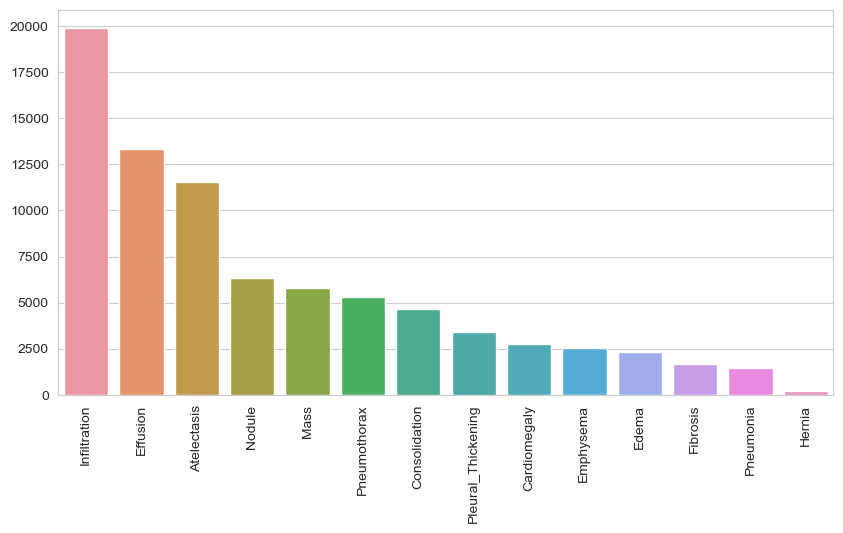

In [68]:
sum = np.zeros(14)

for vector in data["Disease Vector"]:
    sum += vector.tolist()

srt = sorted(enumerate(sum), key=lambda x: x[1], reverse=True)

# bar plot x vs y
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=[unique_diseases[i] for i, _ in srt], y=[i for _, i in srt])
plt.xticks(rotation=90)
plt.show()

In [69]:
all_sorted_cnt = data["Disease Vector"].value_counts()

In [70]:
IMAGE_COUNT = 500

# Define a function get list of diseases in vectors that have count more than img_count
def get_diseases_with_count_more_than(img_count=IMAGE_COUNT, max_class_count=1):
    return [v for v, count in all_sorted_cnt.items() if count >= img_count and np.sum(v.tolist()) <= max_class_count]

def get_diseases_with_count_less_than(img_count=IMAGE_COUNT, max_class_count=1):
    return [v for v, count in all_sorted_cnt.items() if count < img_count and np.sum(v.tolist()) <= max_class_count]

majority_classes = get_diseases_with_count_more_than(img_count=IMAGE_COUNT)
minority_classes = get_diseases_with_count_less_than(img_count=IMAGE_COUNT)

In [71]:
majority_data = data[data['Disease Vector'].isin(majority_classes)]
minority_data = data[data['Disease Vector'].isin(minority_classes)]

In [72]:
len(majority_data), len(minority_data)

(90892, 432)

In [73]:
import tensorflow as tf
from sklearn.utils import resample

# Set the class threshold to 1000
# Resample the minority classes
balanced_data = pd.DataFrame()
for vector in minority_classes:
    # Get the data for the current class
    class_data = minority_data[minority_data['Disease Vector'] == vector]
    # Resample the data
    resampled_class_data = resample(class_data, replace=True, n_samples=IMAGE_COUNT, random_state=42)
    # Append the resampled data to the resampled minority data
    balanced_data = pd.concat([balanced_data, resampled_class_data])

# Sample the majority classes
for vector in majority_classes:
    # Get the data for the current class
    class_data = majority_data[majority_data['Disease Vector'] == vector]
    # Sample the data
    sampled_class_data = class_data.sample(n=IMAGE_COUNT, random_state=42)
    # Append the sampled data to the resampled minority data
    balanced_data = pd.concat([balanced_data, sampled_class_data])

# Shuffle the data
balanced_data = balanced_data.sample(frac=1, random_state=42)

unique_vectors, counts = np.unique(data["Disease Vector"].values, return_counts=True)

In [74]:
balanced_data.head()

,image_path,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Patient is F,Position is AP,Disease Vector
10106,data/images_001/images/00000385_001.png,Hernia,1,385,71,F,PA,True,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
97548,data/images_010/images/00021127_016.png,Emphysema,16,21127,64,M,PA,False,False,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
46672,data/images_012/images/00030637_023.png,Infiltration,23,30637,49,M,PA,False,False,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
40267,data/images_007/images/00014849_000.png,Fibrosis,0,14849,57,M,PA,False,False,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
45097,data/images_012/images/00028317_013.png,Emphysema,13,28317,53,M,AP,False,True,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [75]:
vector, counts = np.unique(balanced_data["Disease Vector"].values, return_counts=True)
for v, cnt in sorted(zip(vector, counts), key=lambda x: x[1], reverse=True):
    print(decode_vector(v), cnt)

['No Finding'] 500
['Hernia'] 500
['Mass'] 500
['Nodule'] 500
['Cardiomegaly'] 500
['Pleural_Thickening'] 500
['Pneumonia'] 500
['Effusion'] 500
['Fibrosis'] 500
['Emphysema'] 500
['Edema'] 500
['Pneumothorax'] 500
['Infiltration'] 500
['Consolidation'] 500
['Atelectasis'] 500


In [76]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 10106 to 63137
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_path      7500 non-null   object
 1   Finding Labels  7500 non-null   object
 2   Follow-up #     7500 non-null   int64 
 3   Patient ID      7500 non-null   int64 
 4   Patient Age     7500 non-null   int64 
 5   Patient Gender  7500 non-null   object
 6   View Position   7500 non-null   object
 7   Patient is F    7500 non-null   bool  
 8   Position is AP  7500 non-null   bool  
 9   Disease Vector  7500 non-null   object
dtypes: bool(2), int64(3), object(5)
memory usage: 542.0+ KB


In [77]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 10106 to 63137
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_path      7500 non-null   object
 1   Finding Labels  7500 non-null   object
 2   Follow-up #     7500 non-null   int64 
 3   Patient ID      7500 non-null   int64 
 4   Patient Age     7500 non-null   int64 
 5   Patient Gender  7500 non-null   object
 6   View Position   7500 non-null   object
 7   Patient is F    7500 non-null   bool  
 8   Position is AP  7500 non-null   bool  
 9   Disease Vector  7500 non-null   object
dtypes: bool(2), int64(3), object(5)
memory usage: 542.0+ KB


In [78]:
# From balanaced_data select 'image_path', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient is F', 'Position is AP' and 'Disease Vector' columns

selected_data = balanced_data[['image_path', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient is F', 'Position is AP', 'Disease Vector']].copy()

In [79]:
# standardize the data except the image_path column
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
selected_data.iloc[:, 1:6] = scaler.fit_transform(selected_data.iloc[:, 1:6])

In [80]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 10106 to 63137
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_path      7500 non-null   object 
 1   Follow-up #     7500 non-null   float64
 2   Patient ID      7500 non-null   float64
 3   Patient Age     7500 non-null   float64
 4   Patient is F    7500 non-null   float64
 5   Position is AP  7500 non-null   float64
 6   Disease Vector  7500 non-null   object 
dtypes: float64(5), object(2)
memory usage: 468.8+ KB


In [81]:
selected_data.head()

,image_path,Follow-up #,Patient ID,Patient Age,Patient is F,Position is AP,Disease Vector
10106,data/images_001/images/00000385_001.png,-0.511448,-1.603785,1.270220,1.110917,-0.81491,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
97548,data/images_010/images/00021127_016.png,0.402432,0.871033,0.870444,-0.900157,-0.81491,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
46672,data/images_012/images/00030637_023.png,0.828910,2.005712,0.013783,-0.900157,-0.81491,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
40267,data/images_007/images/00014849_000.png,-0.572374,0.121978,0.470669,-0.900157,-0.81491,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
45097,data/images_012/images/00028317_013.png,0.219656,1.728903,0.242226,-0.900157,1.22713,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [82]:
# Split data into train and test sets

X = selected_data.iloc[:, 0:6]
y = selected_data.iloc[:, 6].map(lambda x: np.array(x.tolist(), dtype=np.float32))

In [83]:
X.head()

,image_path,Follow-up #,Patient ID,Patient Age,Patient is F,Position is AP
10106,data/images_001/images/00000385_001.png,-0.511448,-1.603785,1.270220,1.110917,-0.81491
97548,data/images_010/images/00021127_016.png,0.402432,0.871033,0.870444,-0.900157,-0.81491
46672,data/images_012/images/00030637_023.png,0.828910,2.005712,0.013783,-0.900157,-0.81491
40267,data/images_007/images/00014849_000.png,-0.572374,0.121978,0.470669,-0.900157,-0.81491
45097,data/images_012/images/00028317_013.png,0.219656,1.728903,0.242226,-0.900157,1.22713


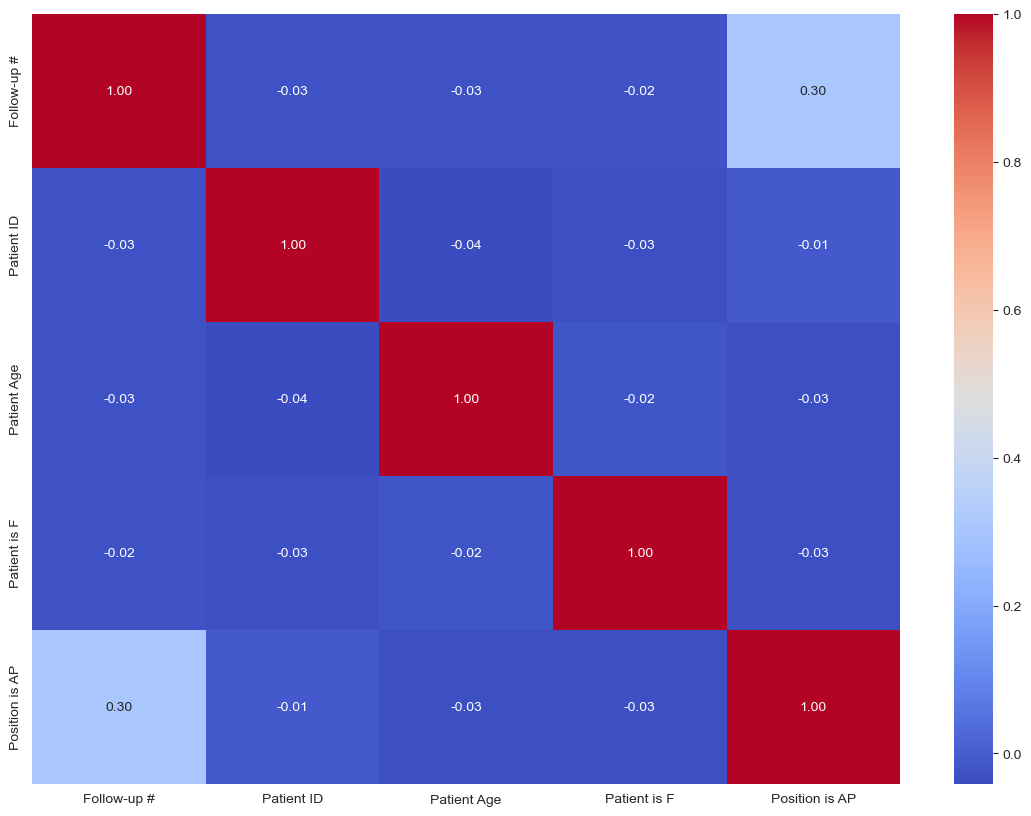

In [84]:
# Correlation matrix of image_paths

plt.figure(figsize=(14, 10))
sns.heatmap(data.iloc[:, 1:].corr(numeric_only=True),
            annot=True,
            fmt=".2f",
            cmap="coolwarm")
plt.show();

In [85]:
X = X.iloc[:, 0]

In [86]:
X.head()

10106    data/images_001/images/00000385_001.png
97548    data/images_010/images/00021127_016.png
46672    data/images_012/images/00030637_023.png
40267    data/images_007/images/00014849_000.png
45097    data/images_012/images/00028317_013.png
Name: image_path, dtype: object

In [87]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42)

len(X_train), len(X_valid), len(y_train), len(y_valid)

(6000, 1500, 6000, 1500)

### Preprocessing images

To preprocess images into Tensors one's going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert RGB values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [88]:
IMG_SIZE = 224

import tensorflow as tf

def process_image(image_path, img_size=IMG_SIZE):
    """
    Create a function to preprocess images using tensorflow
    Load grayscale image with image_path as Tensor
    Turn image into Tensor
    Convert to RGB
    Convert to 0-255 to 0-1
    Resize image to [img_size, img_size]
    :param image_path: Image filepath
    :param img_size: Image size
    :return: Preprocessed image
    """
    # Read in an image file using
    img =tf.io.read_file(image_path)
    # decode grayscale png
    img = tf.image.decode_png(img, channels=3)
    # convert [0-255] to [0-1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize image
    img = tf.image.resize(img, size=[img_size, img_size])

    return img

In [89]:
# Let's test function with a random image
image = process_image(X_train.iloc[1]);

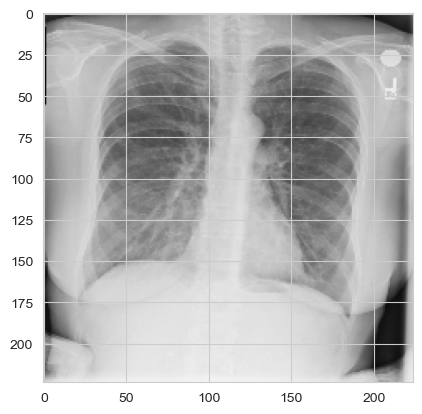

In [90]:
# display image
plt.imshow(image)

### Creating data batches

To create data batches, one's going to use the `tf.data` module which can help speed up our modelling process.

Since we're dealing with image data, it's a good idea to read our data in order. There are two main methods we can use to do this:

* `tf.data.Dataset.from_tensor_slices()` - Reads in data from slices (in our case, slices of an array of image paths and labels).

In [91]:
def get_image_label(image_path, label):
    """
    Get image and label
    :param image_path: Image filepath
    :param label: Image label
    :return: Image and label
    """
    image = process_image(image_path)
    return image, label

path = X_train.values[0]
label = y_train.values[0]

tpl = get_image_label(path, label)
tpl

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.67933166, 0.67933166, 0.67933166],
         [0.06020408, 0.06020408, 0.06020408],
         [0.05764306, 0.05764306, 0.05764306],
         ...,
         [0.06430566, 0.06430566, 0.06430566],
         [0.05714276, 0.05714276, 0.05714276],
         [0.07491329, 0.07491329, 0.07491329]],
 
        [[0.05938376, 0.05938376, 0.05938376],
         [0.05742297, 0.05742297, 0.05742297],
         [0.04733894, 0.04733894, 0.04733894],
         ...,
         [0.03921569, 0.03921569, 0.03921569],
         [0.05570202, 0.05570202, 0.05570202],
         [0.06304532, 0.06304532, 0.06304532]],
 
        [[0.05786315, 0.05786315, 0.05786315],
         [0.04733894, 0.04733894, 0.04733894],
         [0.05746299, 0.05746299, 0.05746299],
         ...,
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.04039645, 0.04039645, 0.04039645]],
 
        ...,
 
        [[0.5013405 , 0.5013405 

In [92]:
# Define batch size
BATCH_SIZE = 128
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels

    y = list(y)

    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    else:
        # If the data is a training dataset, we want to shuffle it
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y))) # labels
        # Shuffling pathname and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the data into batches
        data_batch = data.batch(batch_size)
        return data_batch


In [93]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [94]:
# Check out the different attributes of our data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)))

### Visualizing training data batches

To visualize training data batches, one's going to write a function which does a few things:
1. Take a batch of images and labels from a training dataset as input
2. Unpack the batch into images and labels
3. Plot the images and labels in a grid
4. Return the plotted grid
5. Plot a single image and label from a training dataset
6. Return the plotted image and label
7. Plot a batch of images and labels from a training dataset
8. Return the plotted grid
9. Plot a batch of images and labels from a validation dataset
10. Return the plotted grid
11. Plot a batch of images and labels from a test dataset
12. Return the plotted grid

In [95]:
def get_conditions(label):
    """
    Get conditions from labels
    :param label:
    :return: Conditions string
    """
    return "|".join(decode_vector(label))

import matplotlib.pyplot as plt
import numpy as np

# Create a function for viewing images in a data batch
def show_n_images(images, labels, n=25):
    """
    Displays a plot of images with their labels.
    :param images: Image
    :param labels: Labels
    :param n: Number of images to display
    :return: Plot of images and labels
    """
    # Create a figure with subplots
    x = int(np.ceil(n / 5))
    plt.figure(figsize=(10, int(10*n/25)))
    # Loop through n (for displaying 25 images)
    for i in range(n):
        # Create subplots (x rows, 5 columns)
        ax = plt.subplot(x, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        title = get_conditions(labels[i])
        plt.title(title, fontsize=8)
        # Turn the grid lines off
        plt.axis("off")
        plt.tight_layout()
    plt.show()
# Now let's visualize a batch of training data
images, labels = next(train_data.as_numpy_iterator())

In [ ]:
show_at_once = min(BATCH_SIZE, 25)
show_n_images(images, labels, show_at_once);

In [ ]:
# Now let's visualize our validation set
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_n_images(val_images, val_labels, show_at_once);

In [ ]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
OUTPUT_SHAPE = len(unique_diseases)
# best pretrained model for chest x-ray images 14-classes classification
MODEL_URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
# LR = 0.001
LR=0.004
# MODEL_URL = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
# LR = 0.04

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL, hidden_layer=128):

    # Download the pretrained model and save it as a Keras layer
    keras_layer = hub.KerasLayer(model_url,
                                 trainable=False, # freeze the already learned patterns
                                 name="inputs", # name the layer
                                 input_shape=input_shape[1:]) # input shape to the model

    model = tf.keras.Sequential([
        keras_layer,
        # tf.keras.layers.Dense(hidden_layer, activation="relu"),
        tf.keras.layers.Dense(output_shape, activation="sigmoid", name="outputs")
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LR), # updated optimizer to the latest version
        metrics=['accuracy']
    )

    model.build(input_shape)

    return model



### Model checkpoint, tensorboard saving logs, early stopping callback

In [ ]:
import datetime

from tensorflow.keras.callbacks import ReduceLROnPlateau

# scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                 patience=5, min_lr=1e-5, min_delta=0.001, mode='min')

# Create a model checkpoint callback which saves the model's weights only
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_weights_only=True,
    save_best_only=True,
    save_freq=5,  # save weights after every 5 epochs
    verbose=1,
    mode="min",
    save_format="h5"
)


# Create a model saving logs callback for tensorboard
log_dir = "data/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=2)

# Create early stopping callback model = fit_model();
# loss,categorical_accuracy,val_loss,val_categorical_accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3,
                                                  start_from_epoch=3)



### Training model (on a subset of data)

We'll train our model on a subset of data (IMAGE_COUNT=1000) to see how it performs.

In [ ]:
# Setting NUM_EPOCHS
NUM_EPOCHS = 100

In [ ]:
# Check which GPU is available
print("GPU", "available (YAY!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Let's create functions to trains our model

1. Call create_model()
2. Set our callbacks: early_stopping / tensorboard_callback / model_checkpoint
3. Fit the model on the subset of the training data
4. Returns the model

In [ ]:
# Build a function to train and return a trained model
def fit_model():
    """
    Let’s create functions to trains our model
    Call create_model()
    Set our callbacks: early_stopping / tensorboard_callback / model_checkpoint
    Fit the model on the subset of the training data

    :return: Returns the model
    """

    # Create the model
    model = create_model()

    print("Model summary:", model.summary())

    # Fit the model to the data passing it the callbacks we created
    model.fit(train_data,
              epochs=NUM_EPOCHS,
              validation_data=valid_data,
              validation_freq=1,
              callbacks=[early_stopping, lr_scheduler])

    return model

In [ ]:
# Fit the model to the data
model = fit_model();

29/47 [=================>............] - ETA: 9s - loss: 0.3845 - accuracy: 0.0908

2023-02-13 11:35:23.443018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.1078

2023-02-13 11:35:32.567357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 32s 647ms/step - loss: 0.3342 - accuracy: 0.1078 - val_loss: 0.2363 - val_accuracy: 0.1733 - lr: 0.0040
Epoch 2/100
10/47 [=====>........................] - ETA: 18s - loss: 0.2260 - accuracy: 0.2133

2023-02-13 11:35:44.508447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 30s 640ms/step - loss: 0.2239 - accuracy: 0.2298 - val_loss: 0.2268 - val_accuracy: 0.2280 - lr: 0.0040
Epoch 3/100
31/47 [==================>...........] - ETA: 8s - loss: 0.2113 - accuracy: 0.2908

2023-02-13 11:36:25.267628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 30s 632ms/step - loss: 0.2109 - accuracy: 0.2875 - val_loss: 0.2218 - val_accuracy: 0.2353 - lr: 0.0040
Epoch 4/100
27/47 [================>.............] - ETA: 10s - loss: 0.2001 - accuracy: 0.3345

2023-02-13 11:36:53.269303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 30s 637ms/step - loss: 0.2002 - accuracy: 0.3340 - val_loss: 0.2285 - val_accuracy: 0.2373 - lr: 0.0040
Epoch 5/100
20/47 [===========>..................] - ETA: 13s - loss: 0.1893 - accuracy: 0.3953

2023-02-13 11:37:20.068575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 30s 638ms/step - loss: 0.1920 - accuracy: 0.3740 - val_loss: 0.2245 - val_accuracy: 0.2440 - lr: 0.0040
Epoch 6/100
 2/47 [>.............................] - ETA: 22s - loss: 0.1738 - accuracy: 0.4297

2023-02-13 11:37:40.998494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 30s 628ms/step - loss: 0.1849 - accuracy: 0.4112 - val_loss: 0.2237 - val_accuracy: 0.2500 - lr: 0.0040
Epoch 7/100
37/47 [======================>.......] - ETA: 4s - loss: 0.1775 - accuracy: 0.4367

2023-02-13 11:38:27.925681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 29s 622ms/step - loss: 0.1787 - accuracy: 0.4302 - val_loss: 0.2223 - val_accuracy: 0.2673 - lr: 0.0040
Epoch 8/100
 1/47 [..............................] - ETA: 33s - loss: 0.1640 - accuracy: 0.4844

2023-02-13 11:38:39.475704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 29s 619ms/step - loss: 0.1734 - accuracy: 0.4615 - val_loss: 0.2246 - val_accuracy: 0.2567 - lr: 0.0040
Epoch 9/100
 2/47 [>.............................] - ETA: 22s - loss: 0.1684 - accuracy: 0.4844

2023-02-13 11:39:09.078219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 29s 620ms/step - loss: 0.1616 - accuracy: 0.5138 - val_loss: 0.2209 - val_accuracy: 0.2673 - lr: 8.0000e-04
Epoch 10/100
 3/47 [>.............................] - ETA: 21s - loss: 0.1624 - accuracy: 0.5286

2023-02-13 11:39:38.744939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 29s 620ms/step - loss: 0.1599 - accuracy: 0.5265 - val_loss: 0.2198 - val_accuracy: 0.2747 - lr: 8.0000e-04
Epoch 11/100
14/47 [=======>......................] - ETA: 16s - loss: 0.1596 - accuracy: 0.5446

2023-02-13 11:40:13.467962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 29s 619ms/step - loss: 0.1591 - accuracy: 0.5320 - val_loss: 0.2204 - val_accuracy: 0.2687 - lr: 8.0000e-04
Epoch 12/100
 7/47 [===>..........................] - ETA: 19s - loss: 0.1560 - accuracy: 0.5391

2023-02-13 11:40:39.424300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 29s 620ms/step - loss: 0.1577 - accuracy: 0.5327 - val_loss: 0.2202 - val_accuracy: 0.2720 - lr: 8.0000e-04
Epoch 13/100


2023-02-13 11:41:05.059849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


47/47 [==============================] - 29s 620ms/step - loss: 0.1569 - accuracy: 0.5410 - val_loss: 0.2216 - val_accuracy: 0.2627 - lr: 8.0000e-04


In [108]:
%tensorboard --load_fast=false --bind_all --logdir "/Users/blazej.przybyszewski/Desktop/src/chest-xray-classification/data/logs"

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
%tensorboard --logdir "/Users/blazej.przybyszewski/Desktop/src/data/logs"